<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>


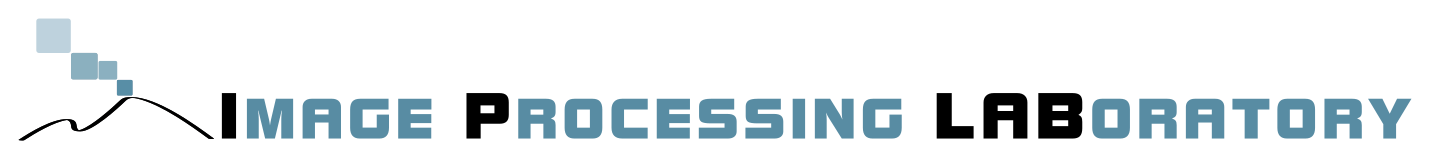

<center><h2>Deep Learning - A.A. 2021-2022</h2></center>
<center><h3>PyTorch Lightning, Autoencoders</h3></center>
<br>
<center>Antonino Furnari - <a href="http://www.antoninofurnari.it/" target="_blank">http://www.antoninofurnari.it/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella - <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

In questo laboratorio impareremo a utilizzare PyTorch Lightning, affronteremo gli autoncoder e vedremo la loro applicazione ai problemi dell'apprendimento di rappresentazioni non supervisionato, della riduzione della dimensionalità e della anomaly detection.

Definiamo una costante pari al numero di epoche per il quale alleneremo i modelli. Imposteremo questa pari a $150$ per la versione "full" del notebook, ma per sperimentare, possiamo anche mettere un numero inferiore di epoche:

In [1]:
NUM_EPOCHS = 100

Imposiamo i seed per riproducilibilità:

In [2]:
import torch
import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# 1 PyTorch Lightning

Durante il corso di Machine Learning, abbiamo imparato a programmare modelli di machine learning e a ottimizzarne i parametri mediante delle procedure di training. In quel contesto, abbiamo spesso scritto i codici di ottimizzazione, valutazione e monitoring delle procedure di training a mano e partendo da zero. Questo codice, spesso identico per modelli e task diversi, viene comunemente chiamato "boilerplate". In pratica, quando si programmano modelli complessi, è utile evitare di scrivere tale codice a mano ogni volta e conviene invece affidarsi a delle librerie che forniscono delle versioni pronte all'uso di tali componenti software. Utilizzare queste librerie permette di risparmiare tempo, evitare di introdurre errori e sfruttare versioni già ottimizzate di codice di uso comune.

In questo laboratorio introdurremo PyTorch Lightning, una libreria progettata per rendere semplice il training e la valutazione di modelli complessi. Oltre a evitare la codifica di codice "boilerplate", Lightning rende semplice accedere a funzionalità avanzate quali l'utilizzo dei modelli in precisione singola (16 bit) e il training parallelo nei cluster. In questo laboratorio vedremo le basi di PyTorch Lightning. Maggiori risorse, inclusa una lunga lista di tutorial, è disponibile sul sito di PyTorch Lightning: https://www.pytorchlightning.ai/.

Per installare PyTorch Lightning, è sufficiente digitare il comando: `pip install pytorch_lightning`.

## 1.1 PyTorch Lightning - Un semplice esempio

Inizieremo vedendo un semplice esempio che mostra come sia semplice codificare e fare training di modelli mediante PyTorch Lightning. Inizieremo costruendo un semplice MLP per la classificazione delle immagini del dataset MNIST senza utilizzare codice PyTorch. Iniziamo con le import:

In [3]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from os.path import join
from sklearn.metrics import accuracy_score
from torch.optim import SGD
import numpy as np

Di seguito il codice:

In [4]:
# Definiamo il modello
class MLPClassifier(nn.Module):
    def __init__(self, in_features, hidden_units, out_classes):
        """Costruisce un classificatore MLP.
            Input:
                in_features: numero di feature in input (es. 784)
                hidden_units: numero di unità nel livello nascosto (es. 512)
                out_classes: numero di classi in uscita (es. 10)"""
        super(MLPClassifier, self).__init__() 
        self.hidden_layer = nn.Linear(in_features, hidden_units)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(hidden_units, out_classes)
        
    def forward(self,x):
        hidden_representation = self.hidden_layer(x)
        hidden_representation = self.activation(hidden_representation)
        scores = self.output_layer(hidden_representation)
        return scores
    
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,),(0.3081,)),
                               transforms.Lambda(lambda x: x.view(-1))])
    
# Carichiamo training e test set
mnist_train = MNIST(root='data',train=True, download=True, transform=transform)
mnist_test = MNIST(root='data',train=False, download=True, transform=transform)

# Carichiamo i dataloader
mnist_train_loader = DataLoader(mnist_train, batch_size=256, num_workers=4, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=256, num_workers=4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPClassifier(784, 512, 10)

epochs=5

criterion = nn.CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=0.001) 


model.to(device)
for e in range(epochs):
    #training
    model.train()
    with torch.set_grad_enabled(True):
        for i, batch in enumerate(mnist_train_loader):
            x=batch[0].to(device) #portiamoli sul device corretto
            y=batch[1].to(device)
            output = model(x)

            l = criterion(output,y)

            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if i%100==0:
                print(f"[training] Epoca: {e}/{epochs}. Iterazione: {i}/{len(mnist_train_loader)}. Loss: {l.item():0.2f}")
        
    #evaluation
    all_predictions = []
    all_labels = []
    model.eval()
    with torch.set_grad_enabled(False):
        for i, batch in enumerate(mnist_train_loader):
            x=batch[0].to(device) #portiamoli sul device corretto
            y=batch[1].to(device)
            output = model(x)

            all_predictions.append(y.to('cpu').numpy())
            all_labels.append(output.to('cpu').max(1)[1].numpy())
    
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    
    acc = accuracy_score(all_labels,all_predictions)
    
    print(f"[test] Epoca: {e}. Accuracy: {acc:0.2f}")

[training] Epoca: 0/5. Iterazione: 0/235. Loss: 2.30
[training] Epoca: 0/5. Iterazione: 100/235. Loss: 1.96
[training] Epoca: 0/5. Iterazione: 200/235. Loss: 1.66
[test] Epoca: 0. Accuracy: 0.70
[training] Epoca: 1/5. Iterazione: 0/235. Loss: 1.56
[training] Epoca: 1/5. Iterazione: 100/235. Loss: 1.39
[training] Epoca: 1/5. Iterazione: 200/235. Loss: 1.27
[test] Epoca: 1. Accuracy: 0.77
[training] Epoca: 2/5. Iterazione: 0/235. Loss: 1.22
[training] Epoca: 2/5. Iterazione: 100/235. Loss: 1.10
[training] Epoca: 2/5. Iterazione: 200/235. Loss: 0.95
[test] Epoca: 2. Accuracy: 0.80
[training] Epoca: 3/5. Iterazione: 0/235. Loss: 0.99
[training] Epoca: 3/5. Iterazione: 100/235. Loss: 0.92
[training] Epoca: 3/5. Iterazione: 200/235. Loss: 0.82
[test] Epoca: 3. Accuracy: 0.82
[training] Epoca: 4/5. Iterazione: 0/235. Loss: 0.82
[training] Epoca: 4/5. Iterazione: 100/235. Loss: 0.88
[training] Epoca: 4/5. Iterazione: 200/235. Loss: 0.75
[test] Epoca: 4. Accuracy: 0.84


Vediamo adesso lo stesso esempio in PyTorch Lightning:

In [5]:
import pytorch_lightning as pl
class MLPClassifier(pl.LightningModule):
    def __init__(self, in_features, hidden_units, out_classes):
        super(MLPClassifier, self).__init__() 
        self.hidden_layer = nn.Linear(in_features, hidden_units)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(hidden_units, out_classes)
        
    def forward(self,x):
        hidden_representation = self.hidden_layer(x)
        hidden_representation = self.activation(hidden_representation)
        scores = self.output_layer(hidden_representation)
        return scores
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.001) 
        return optimizer
    
    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = criterion(output,y)
        self.log('train/loss', loss)
        return loss
    
    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        
        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)
        
        self.log('val/accuracy', acc)

# Definiamo dataset e data loader
mnist_train = MNIST(root='data',train=True, download=True, transform=transform)
mnist_val = MNIST(root='data',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=256, num_workers=4, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=256, num_workers=4)

# definiamo il modello
model = MLPClassifier(784, 512, 10)

# definiamo un oggetto trainer
trainer = pl.Trainer(max_epochs=5, gpus=1) #gpus=1 indica che vogliamo usare una sola gpu

# effettuiamo il fit
trainer.fit(model, mnist_train_loader, mnist_test_loader)

# effettuiamo il passaggio di validation per visualizzare le performance finali di validation
trainer.validate()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name         | Type   | Params
----------------------------------------
0 | hidden_layer | Linear | 401 K 
1 | activation   | Tanh   | 0     
2 | output_layer | Linear | 5.1 K 
----------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/accuracy': 0.8458999991416931}
--------------------------------------------------------------------------------


[{'val/accuracy': 0.8458999991416931}]

L'approccio di PyTorch Lightning consiste nell'estendere la classe `LightningModule`. Gli oggetti costruiti a partire da questa classe possono essere utilizzati come un classico oggetto di tipo `nn.Module` ma contengono dei metodi aggiuntivi che verranno poi usati da un oggetto `Trainer` per effettuare il training. I metodi aggiuntivi sono i seguenti:

 * configure_optimizers: costruisce e restituisce l'oggetto optimizer;
 * training_step: definisce come effettuare ciascun training step;
 * validation_step: definisce come effettuare ciascuno step di validazione.
 
Altre funzionalità possono essere ottenute implementando altri metodi. Durante il corso, ne vedremo alcuni esempi.

Una volta costruito l'oggetto `MLPClassifier`, possiamo effettuare il training del modello mediante un oggetto `Trainer` che richiamerà i metodi precedentemente definiti per costruire l'optimizer ed effettuare il training.

Notiamo che i metodi `training_step` e `validation_step` contengono delle chiamate a un metodo `self.log`. Si tratta di un metodo della superclasse `LightningModule` che permette di effettuare il logging di alcuni valori, che verranno in automatico mostrati durante il training per il monitoraggio.

Notiamo inoltre che il codice scritto con Lightning non contiene nessun `to(device)` o `to(cuda)`, che rende semplice adattare il codice per training su una o più GPU o su CPU. Ad esempio per fare training su CPU è sufficiente definire il trainer come segue:

`trainer = pl.Trainer(max_epochs=5, gpus=0)`

Per fare training su due GPU, definiamo il trainer come segue:

`trainer = pl.Trainer(max_epochs=5, gpus=2)`

<div>
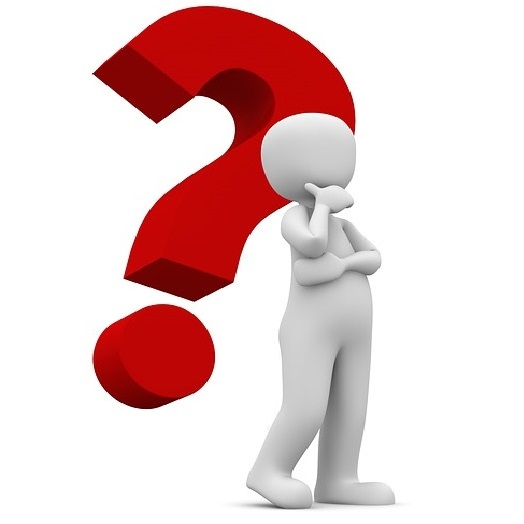
</div>

**Domanda 1**

Si confronti il codice scritto senza l'ausilio di PyTorch Lightning con quello scritto mediante PyTorch Lightning. Quali sono le principali differenze? Quali i vantaggi di un metodo rispetto all'altro?

<div>
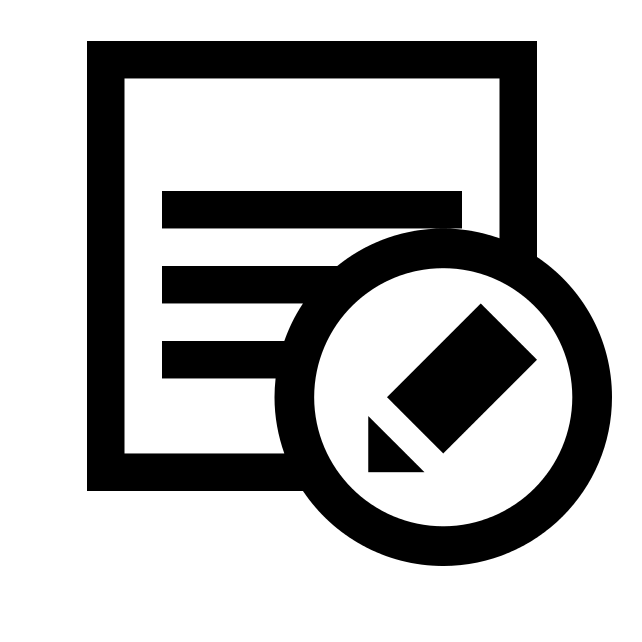
</div>

**Risposta 1**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 1.2 PyTorch Lightning - Funzionalità avanzate

Uno dei vantaggi di PyTorch Lightning è che esso permette un semplice accesso a funzionalità più avanzate, offrendo una grande flessibilità con poche righe di codice. Di seguito, vedremo qualche esempio.

### 1.2.1 Logging mediante Tensorboard

Abilitare il logging mediante Tensorboard è molto semplice. Basta definire un oggetto di tipo `TensorBoardLogger`, inizializzarlo passando la directory in cui salvare i log e il nome dell'esperimento e passare il logger al trainer:

In [6]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = pl.Trainer(max_epochs=5, gpus=1, logger=logger)
trainer.fit(model, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name         | Type   | Params
----------------------------------------
0 | hidden_layer | Linear | 401 K 
1 | activation   | Tanh   | 0     
2 | output_layer | Linear | 5.1 K 
----------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


Aprendo una console di TensorBoard con il comando `tensorboard --logdir tb_logs`, visualizzeremo dei grafici simili al seguente:

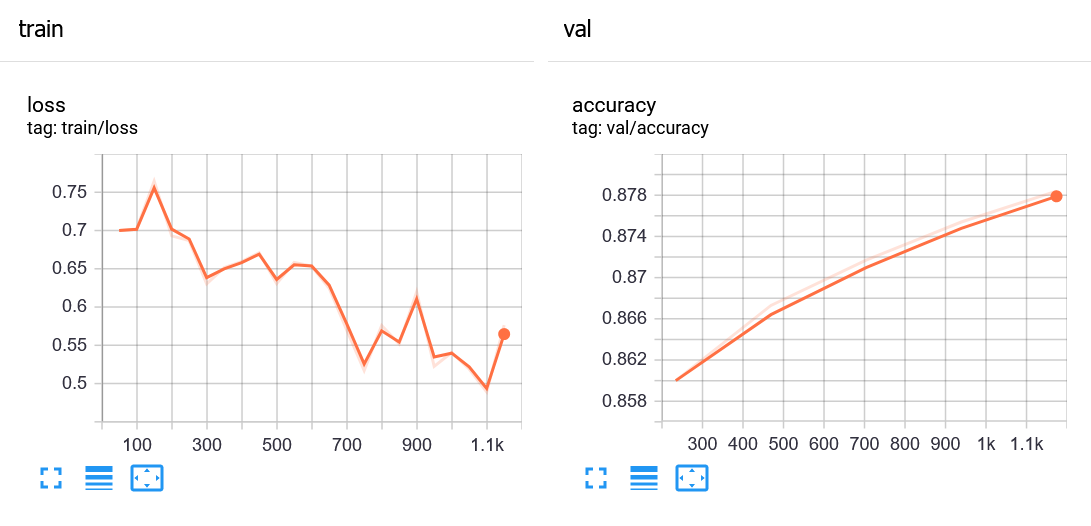

### 1.2.2 Logging Avanzato

La funzione `self.log` permette di effettuare il log delle misure di training e validation. Quando viene effettuata la validazione sull'intero validation set, le misure ottenute per ciascun batch vengono mediate e restituite. Questo metodo è pratico per misurare le performance durante il training, ma poco accurato quando le performance del modello vanno testate. Infatti, il metodo più accurato consisterebbe conservare tutte le predizioni ed etichette e calcolare l'accuracy solo alla fine dell'epoca di validazione. 

Per implementare il logging in questo modo, possiamo sovrascrivere un metodo `validation_epoch_end`:

In [7]:
class MLPClassifier(pl.LightningModule):
    def __init__(self, in_features, hidden_units, out_classes):
        super(MLPClassifier, self).__init__() 
        self.hidden_layer = nn.Linear(in_features, hidden_units)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(hidden_units, out_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self,x):
        hidden_representation = self.hidden_layer(x)
        hidden_representation = self.activation(hidden_representation)
        scores = self.output_layer(hidden_representation)
        return scores
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.001) 
        return optimizer
    
    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output,y)
        self.log('train/loss', loss)
        return loss
    
    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        
        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)
        
        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }
        
    def validation_epoch_end(self, outputs):
        #concateniamo tutte le predizioni 
        predictions = np.concatenate([o['predictions'] for o in outputs])
        #concateniamo tutte le etichette
        labels = np.concatenate([o['labels'] for o in outputs])
        
        acc = accuracy_score(labels, predictions)
        
        self.log('val/accuracy', acc)

# Definiamo dataset e data loader
mnist_train = MNIST(root='data',train=True, download=True, transform=transform)
mnist_val = MNIST(root='data',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=256, num_workers=4, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=256, num_workers=4)

# definiamo il modello
model = MLPClassifier(784, 512, 10)

# definiamo un oggetto trainer
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1) #gpus=1 indica che vogliamo usare una sola gpu

# effettuiamo il fit
trainer.fit(model, mnist_train_loader, mnist_test_loader)

# effettuiamo il passaggio di validation per visualizzare le performance finali di validation
trainer.validate()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name         | Type             | Params
--------------------------------------------------
0 | hidden_layer | Linear           | 401 K 
1 | activation   | Tanh             | 0     
2 | output_layer | Linear           | 5.1 K 
3 | criterion    | CrossEntropyLoss | 0     
--------------------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/accuracy': 0.9247999787330627}
--------------------------------------------------------------------------------


[{'val/accuracy': 0.9247999787330627}]

# 2 Autoencoders

Gli autoencoder costituiscono una categoria di algoritmi di learning di tipo "self-supervised" (auto-supervisionati). Gli autoencoder vengono utilizzati per compressione dei dati, riduzione della dimensionalità ai fini della visualizzazione e per apprendere rappresentazioni più in generale. 

Un autoencoder è una rete composta di due componenti:
 * Un encoder, che mappa i dati in uno spazio di dimensionalità inferiore. La rappresentazione ottenuta in questo livello viene generalmente detta "codice" relativo al dato in input;
 * Un decoder, che ricostruisce i dati in input a partire dal loro codice di dimensionalità inferiore.
 
Un esempio di autoencoder composto di layer fully connected è il seguente:

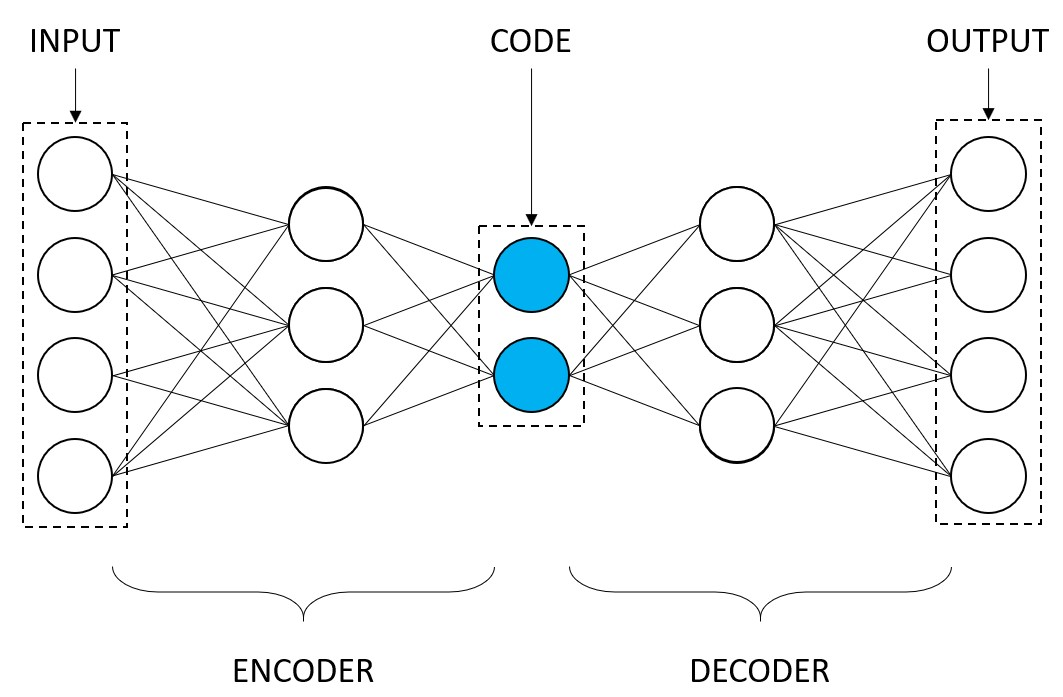

<div>
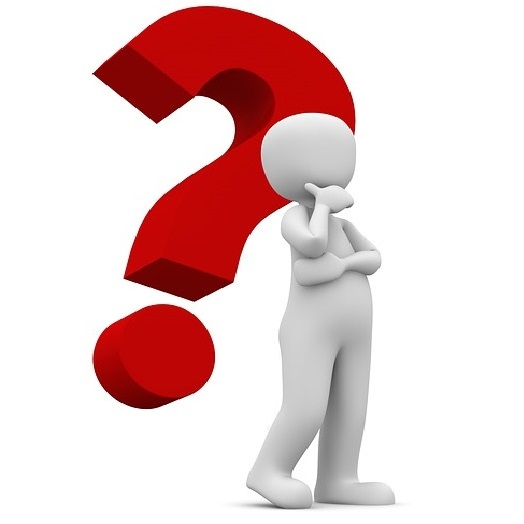
</div>

**Domanda 2**

Il codice dell'autoencoder ha una dimensionalità ridotta rispetto all'input. Questa è una pratica comune. Quali sarebbero i rischi di avere un codice di dimensione pari a quella di input?

<div>
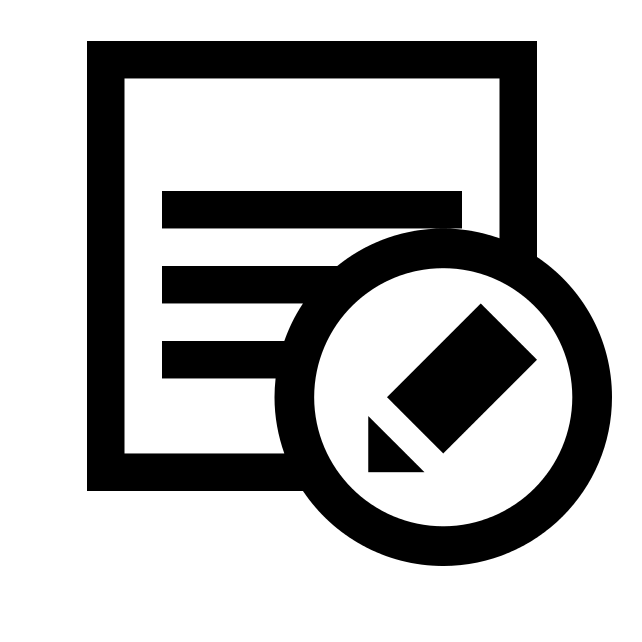
</div>

**Risposta 2**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Nell'esempio, l'input è di $4$ unità. L'encoder è un MLP che mappa questo input in un codice a dimensionalità inferiore pari a $2$ unità. Il decoder è un altro MLP che mappa il codice in un output della stessa dimensionalità dell'input ($4$ unità). Per ottenere un modello non lineare, alla fine di ogni livello eccetto l'ultimo viene inserita una funzione di attivazione.

Il modello viene allenato per regredire i valori di input applicando una loss di regressione (MSE) tra l'input e l'output. La cosa interessante di questo schema di training è che non è necessario di nessuna etichetta in fase di training.

Ci si aspetta che un autoencoder ben allenato sia in grado di:
 * Effettuare data compression: l'encoder può essere utilizzato per comprimere i dati, mentre il decoder può essere utilizzato per decomprimerli;
 * Effettuare dimensionality reduction: ci si aspetta che, se il decoder è capace di ricostruire il dato in input a partire dal suo codice, il codice possa essere una buona rappresentazione del dato in input;
 * Ottenere una rappresentazione utile anche per altri task (es. classificazione): ci si aspetta che il codice includa informazioni utili per la loro classificazione.

## 2.1 Autoencoder Fully Connected
Vediamo un esempio di Autoencoder fully connected che alleneremo dataset MNIST. Iniziamo caricando il dataset e definendo i data loader:

In [8]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,)),
                                torch.flatten]) #flatten serve per convertire le immagini in vettori di 784 unità 
mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=2, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=2)

Definiamo a questo punto un autoencoder fully connected che prenda in input le immagini sotto forma di vettori di $784$ unità, le mappi in un codice di $128$ unità e ricostruisca l'input di $784$ unità:

In [9]:
from torchvision.utils import make_grid

class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        
        #l'encoder è un MLP che mappa l'input in un codice di 128 unità
        #dato che l'ultimo livello dell'MLP non è l'ultimo della rete,
        #inseriamo una attivazione alla fine dell'MLP
        self.encoder = nn.Sequential(nn.Linear(784, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 128),
                                     nn.ReLU())
        
        #il decoder è un MLP che mappa il codice in un output di dimensione uguale all'input
        self.decoder = nn.Sequential(nn.Linear(128, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 784))
        
        #la loss che utilizzeremo per il training
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        #restituiamo sia il codice che l'output ricostruito
        return code, reconstructed
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.01, momentum=0.99) 
        return optimizer
    
    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, _ = train_batch
        _, reconstructed = self.forward(x)
        loss = self.criterion(x, reconstructed)
        
        self.log('train/loss', loss)
        return loss
    
    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, _ = val_batch
        _, reconstructed = self.forward(x)
        loss = self.criterion(x, reconstructed)
        
        self.log('val/loss', loss)
        if batch_idx==0:
            return {'inputs':x, 'outputs':reconstructed}
        
    def validation_epoch_end(self, results):
        images_in = results[0]['inputs'].view(-1,1,28,28)[:50,...]
        images_out = results[0]['outputs'].view(-1,1,28,28)[:50,...]
        self.logger.experiment.add_image('input_images', make_grid(images_in, nrow=10, normalize=True),self.global_step)
        self.logger.experiment.add_image('generated_images', make_grid(images_out, nrow=10, normalize=True),self.global_step)

Il modulo sopra segue lo schema visto in precedenza, con alcune differenze:
 * Durante il validation step, restituiamo un batch (il primo) di immagini di input e un batch di immagini ri-generate dall'autoencoder;
 * Alla fine della epoca di validazione, recuperiamo gli input e output prodotti nei validation step e inseriamo una griglia di immagini per ciascuno dei due batch (input e generati). Questo viene fatto mediante chiamate a `self.logger.experiment.add_image`.
 
Effettuiamo il training per 100 epoche:

In [10]:
logger = TensorBoardLogger("tb_logs", name="autoencoder")
    
mnist_autoencoder = Autoencoder()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1, logger=logger) 
trainer.fit(mnist_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 233 K 
1 | decoder   | Sequential | 234 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
468 K     Trainable params
0         Non-trainable params
468 K     Total params
1.873     Total estimated model params size (MB)


/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Alla fine del training, i grafici su tensorboard dovrebbero essere simili ai seguenti:

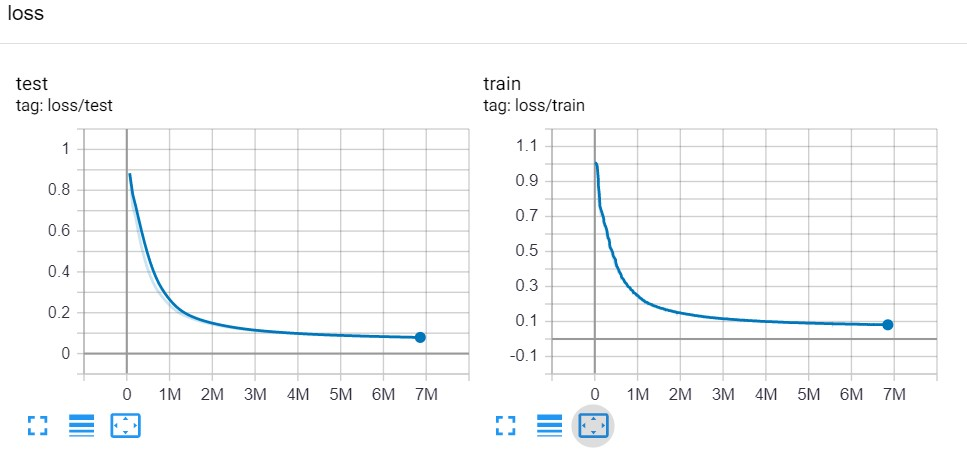

Cliccando su "images" dovremmo riuscire a vedere le immagini di input e le relative immagini ricostruite di cui abbiamo fatto log durante il training:
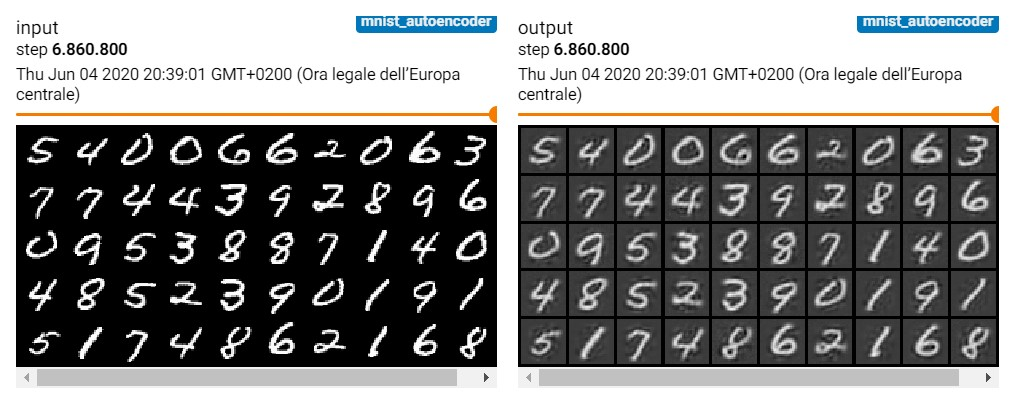

<div>
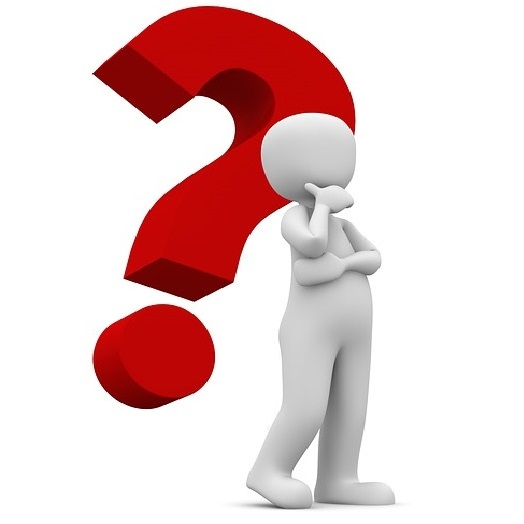
</div>

**Domanda 3**

Si confrontino i dati ricostruiti con i dati originali. La ricostruzione è perfetta? Ci sono degli artefatti? Si confrontino i risultati ottenuti nelle iterazioni intermedie. I numeri sono sempre intellegibili?

<div>
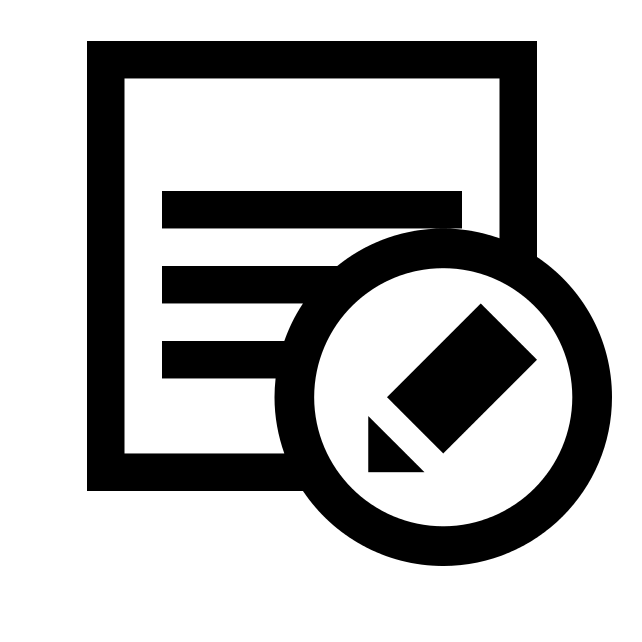
</div>

**Risposta 3**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Abbiamo constatato che il modello è effettivamente capace di ricostruire gli input. Vediamo adesso se i codici estratti dal modello sono in effetti delle buone rappresentazioni degli input. Iniziamo costruendo una funzione per estrarre i codici da tutte le immagini di test:

In [49]:
def extract_codes(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    codes, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        code, *_ = model(x)
        code = code.detach().to('cpu').numpy()
        labels.append(batch[1])
        codes.append(code)
    return np.concatenate(codes), np.concatenate(labels)

Estriamo i codici insieme ai rispettivi labels che non abbiamo usato in fase di training:

In [50]:
codes, labels = extract_codes(mnist_autoencoder, mnist_test_loader)
print(codes.shape, labels.shape)

(10000, 128) (10000,)


Per visualizzare i dati, utilizzeremo la tecnica di visualizzazione dei dati chiamata TSNE (https://it.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) che permette di proiettare i dati in uno spazio a dimensione ridotta preservando le distanze relative tra gli elementi. In particolare, utilizzeremo questa tecnica per proiettare i codici di $128$ unità su due dimensioni che plotteremo sullo spazio 2D. Prima però selezioniamo un sottoinsieme dei codici da visualizzare:

In [51]:
selected_codes = np.random.choice(len(codes),1000)
codes = codes[selected_codes]
labels = labels[selected_codes]

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
codes_tsne=tsne.fit_transform(codes)

A questo punto plottiamo i codici proiettati nello spazio 2D distinguendoli per colore:

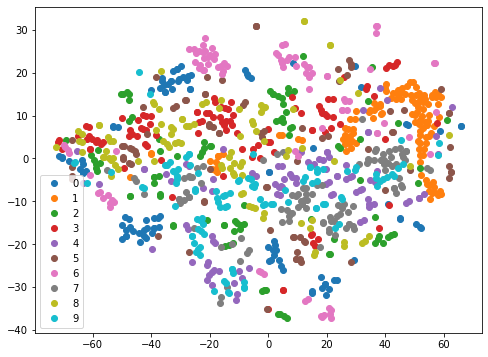

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne[labels==c, 0], codes_tsne[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<div>
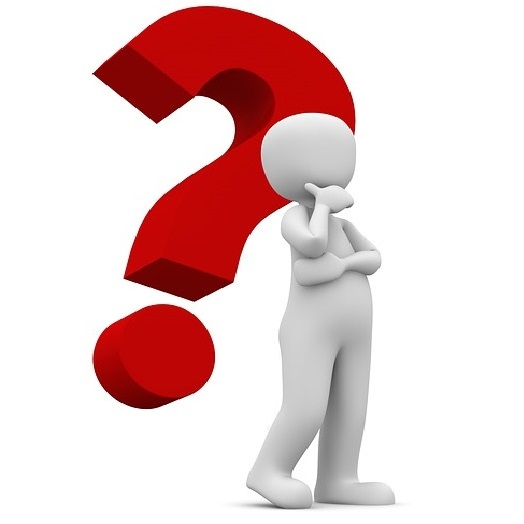
</div>

**Domanda 4**

Si osservi la rappresentazione TSNE dei codici estratti dall'autoencoder. I dati sono ben raggruppati per classe? Si potrebbe fare di meglio? Perché?

<div>
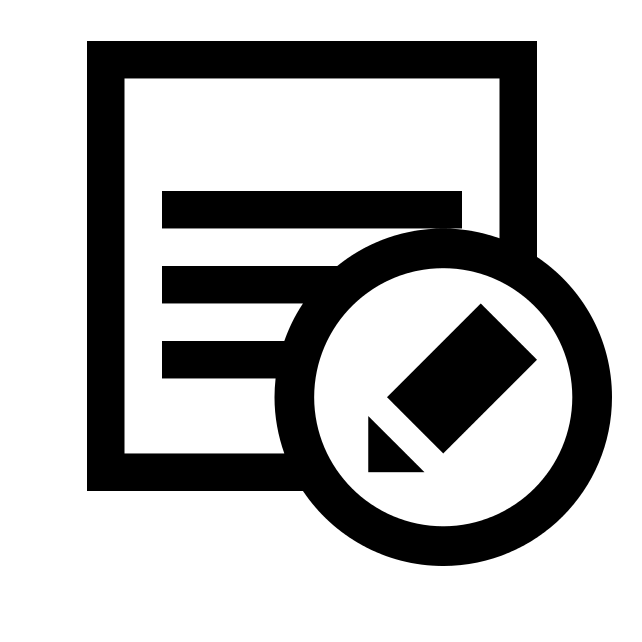
</div>

**Risposta 4**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 2.1 Autoencoder basato su convoluzioni

Vediamo adesso di costruire una versione dell'autoencoder visto in precedenza basato su convoluzioni. In questo caso il codice non sarà un vettore unidimensionale, ma una mappa di feature di dimensionalità minore rispetto a quella in input. 

L'encoder sarà una CNN, con i seguenti accorgimenti:
 * Inseriremo il padding nelle convoluzioni per evitare di ridurre le dimensioni delle mappe di feature. L'unica operazione che ridurrà le dimensioni delle mappe di feature è il poolin;
 * Dato che il nostro obiettivo non è fare classificazione, utilizzeremo l'average pooling al posto del max pooling;
 
Il decoder sarà una CNN speculare all'encoder, con la seguente modifica:
 * Al posto dell'average pooling che riduce le dimensione dell'input di un fattore $s$, utilizzeremo un modulo di "upsampling" che, mediante interpolazione aumenterà le dimensioni dell'input di un fattore $s$;
 
Utilizzeremo solo filtri $3 \times 3$ in questo esempio. Definiamo il modello seguendo lo schema di PyTorch Lightning:

In [16]:
from torchvision.utils import make_grid

class ConvAutoencoder(pl.LightningModule):
    def __init__(self):
        super(ConvAutoencoder, self).__init__() 
        self.encoder = nn.Sequential(nn.Conv2d(1,16,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,8,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,4,3, padding=1),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Conv2d(4,8,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,16,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,1,3, padding=1))
        
        #la loss che utilizzeremo per il training
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.01, momentum=0.99) 
        return optimizer
    
    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, _ = train_batch
        _, reconstructed = self.forward(x)
        loss = self.criterion(x, reconstructed)
        
        self.log('train/loss', loss)
        return loss
    
    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, _ = val_batch
        _, reconstructed = self.forward(x)
        loss = self.criterion(x, reconstructed)
        
        self.log('val/loss', loss)
        if batch_idx==0:
            return {'inputs':x, 'outputs':reconstructed}
        
    def validation_epoch_end(self, results):
        images_in = results[0]['inputs'].view(-1,1,28,28)[:50,...]
        images_out = results[0]['outputs'].view(-1,1,28,28)[:50,...]
        self.logger.experiment.add_image('input_images', make_grid(images_in, nrow=10, normalize=True),self.global_step)
        self.logger.experiment.add_image('generated_images', make_grid(images_out, nrow=10, normalize=True),self.global_step)

<div>
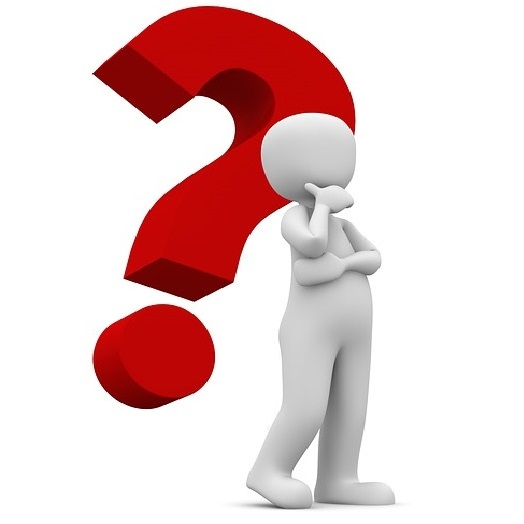
</div>

**Domanda 5**

Si confronti il codice scritto sopra con quello che implementa l'autoencoder Fully Connected. Quali parti sono uguali? Quali diverse?

<div>
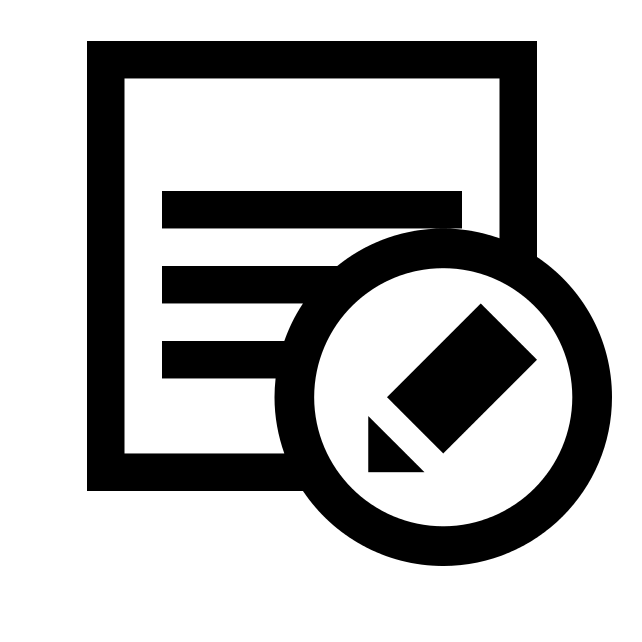
</div>

**Risposta 5**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Prima di allenare il modello, dobbiamo ridefinire dataset e data loaders evitando di introdurre l'operazione `flatten`, in modo da caricare immagini $28 \times 28$ invece di vettori di $784$ elementi:

In [17]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 
mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=2, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=2)

Notiamo che la shape dell'immagine è adesso correttamente $1 \times 28 \times 28$. Effettuiamo adesso il training con l'API di Lightning:

In [18]:
logger = TensorBoardLogger("tb_logs", name="mnist_conv_autoencoder")
    
mnist_conv_autoencoder = ConvAutoencoder()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1, logger=logger) 
trainer.fit(mnist_conv_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.6 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Alla fine del training, i grafici su tensorboard dovrebbero essere simili ai seguenti:

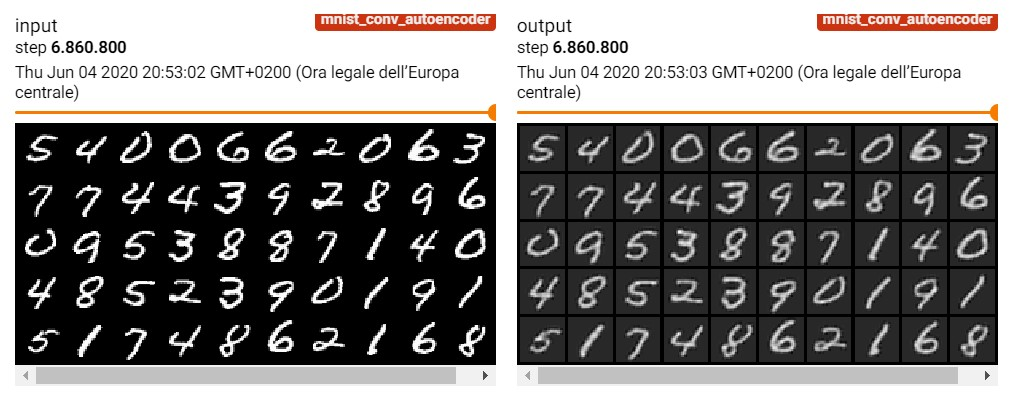
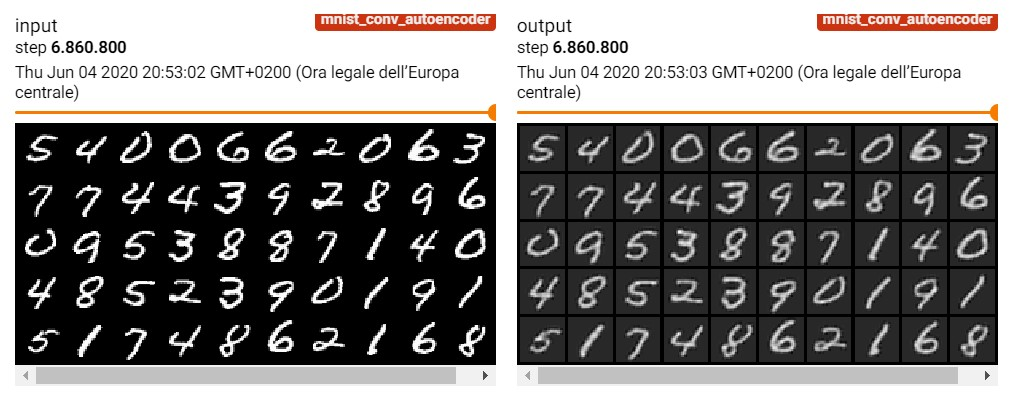


<div>
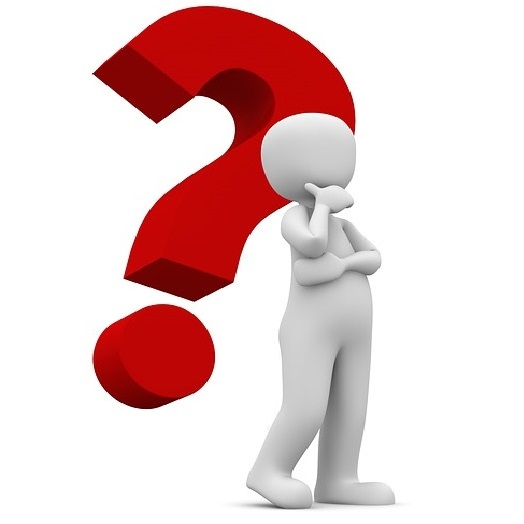
</div>

**Domanda 6**

Si confrontino i risultati ottenuti dal nuovo modello con quelli ottenuti dal vecchio. Quali risultati appaiono migliori? Si utilizzi lo slider per scorrere la history delle immagini generate. In quali dei due cose si raggiungono ricostruzioni accettabili prima? A cosa possono essere dovute le differenze?

<div>
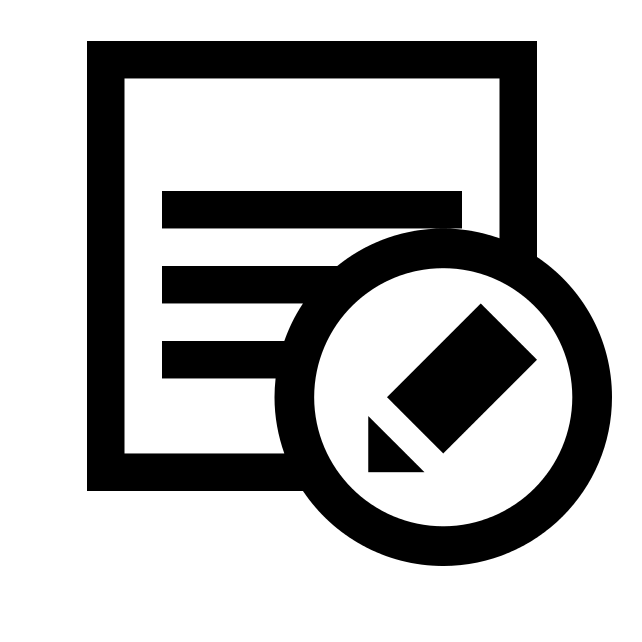
</div>

**Risposta 6**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Estraiamo i codici con il nuovo autoencoder:

In [19]:
codes, labels = extract_codes(mnist_conv_autoencoder, mnist_test_loader)
print(codes.shape, labels.shape)

(10000, 4, 7, 7) (10000,)


I codici sono delle mappe di feature $4 \times 7 \times 7$. Trasformiamoli in vettori monodimensionali e selezioniamo lo stesso sottoinsieme di dati considerati nel caso precedente:

In [20]:
selected_codes = np.random.choice(len(codes),1000)
codes = codes.reshape(codes.shape[0],-1)
codes = codes[selected_codes]
labels = labels[selected_codes]
print(codes.shape)

(1000, 196)


Traformiamo i dati mediante TSNE ed eseguiamo il plot:

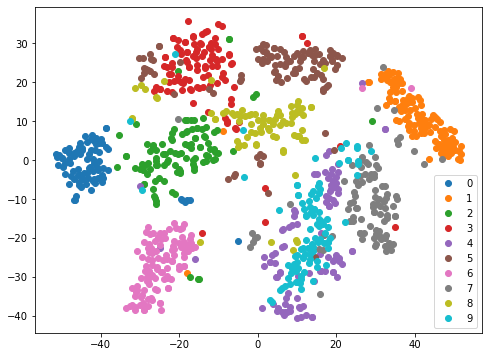

In [21]:
tsne = TSNE(2)
codes_tsne_conv=tsne.fit_transform(codes)

plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne_conv[labels==c, 0], codes_tsne_conv[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<div>
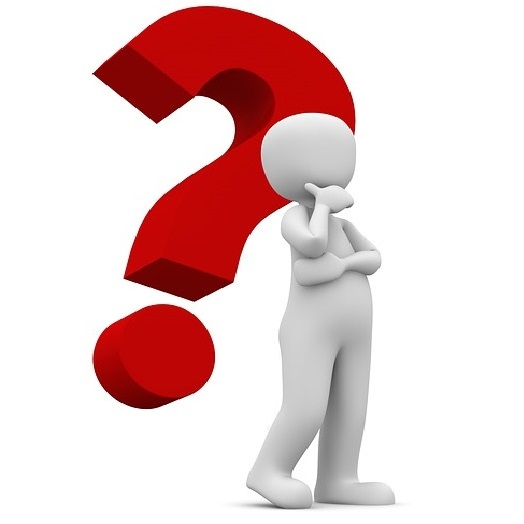
</div>

**Domanda 7**

Si confronti il grafico ottenuto con quello dell'autoencoder senza convoluzioni. Quali dei due trasforma i dati in maniera più "coerente" con le classi? Perché?

<div>
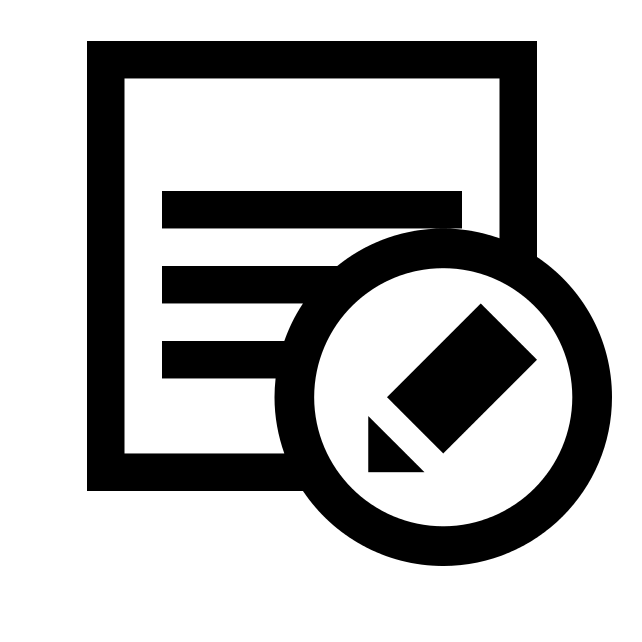
</div>

**Risposta 7**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 3 Denoising Autoencoders e Sparse Autoencoders

In questa sezione vedremo degli esempi di due variazioni degli autoencoders: i denoising autoencoders e gli sparse autoencoders.

## 3.1 Denoising autoencoders

Il principio alla base dei denoising autoencoders è quello perturbare l'immagine di input chiedendo al modello di ricostruire comunque l'immagine non perturbata. Il principale scopo di questa tecnica è evitare che il modello apprenda una funzione identità, che non sarebbe sufficiente a ricostruire l'immagine non perturbata. L'implementazione di un denoising autoencoder è molto semplice: è sufficiente inserire un livello di dropout prima dell'input. Il dropout infatti metterà a zero un certo numero di pixel scelti casualmente. Implementiamo il denoising autoencoder partendo dalla implementazione del convolutional autoencoder:

In [22]:
from torchvision.utils import make_grid

class DenoisingConvAutoencoder(pl.LightningModule):
    def __init__(self):
        super(DenoisingConvAutoencoder, self).__init__() 
        self.encoder = nn.Sequential(nn.Conv2d(1,16,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,8,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,4,3, padding=1),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Conv2d(4,8,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,16,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,1,3, padding=1))
        
        self.criterion = nn.MSELoss()
        
    def forward(self, x, perturb=False):
        #utilizziamo un parametro perturb per stabilire
        #se l'input va perturbato oppure no
        if perturb:
            #Aggiungiamo del rumore random compreso tra -0.5 e 0.5
            #moltiplichiamo per un fattore di rumore che indica quanto 
            #il rumore deve essere presente nell'immagine finale
            noise_factor = 0.5
            x = x + (torch.randn_like(x)-0.5) * noise_factor

        code = self.encoder(x)
        reconstructed = self.decoder(code)
        #restituiamo anche l'immagine perturbata
        #tornerà utile per le visualizzazioni
        return code, reconstructed, x
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.01, momentum=0.99) 
        return optimizer
    
    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, _ = train_batch
        _, reconstructed, perturbed = self.forward(x, perturb=True)
        loss = self.criterion(perturbed, reconstructed)
        
        self.log('train/loss', loss)
        return loss
    
    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, _ = val_batch
        _, reconstructed, perturbed = self.forward(x, perturb=True)
        loss = self.criterion(perturbed, reconstructed)
        
        self.log('val/loss', loss)
        if batch_idx==0:
            return {'inputs':x, 'perturbed': perturbed, 'outputs':reconstructed}
        
    def validation_epoch_end(self, results):
        images_in = results[0]['inputs'].view(-1,1,28,28)[:50,...]
        perturbed = results[0]['perturbed'].view(-1,1,28,28)[:50,...]
        images_out = results[0]['outputs'].view(-1,1,28,28)[:50,...]
        self.logger.experiment.add_image('original_images', make_grid(images_in, nrow=10, normalize=True),self.global_step)
        self.logger.experiment.add_image('perturbed_images', make_grid(perturbed, nrow=10, normalize=True),self.global_step)
        self.logger.experiment.add_image('generated_images', make_grid(images_out, nrow=10, normalize=True),self.global_step)

Adesso effettuiamo il training:

In [23]:
logger = TensorBoardLogger("tb_logs", name="mnist_denoising_conv_autoencoder")
    
mnist_denoising_conv_autoencoder = DenoisingConvAutoencoder()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1, logger=logger) 
trainer.fit(mnist_denoising_conv_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.6 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Alla fine del training, dovremmo visualizzare dei grafici simili a questi su tensorboard:


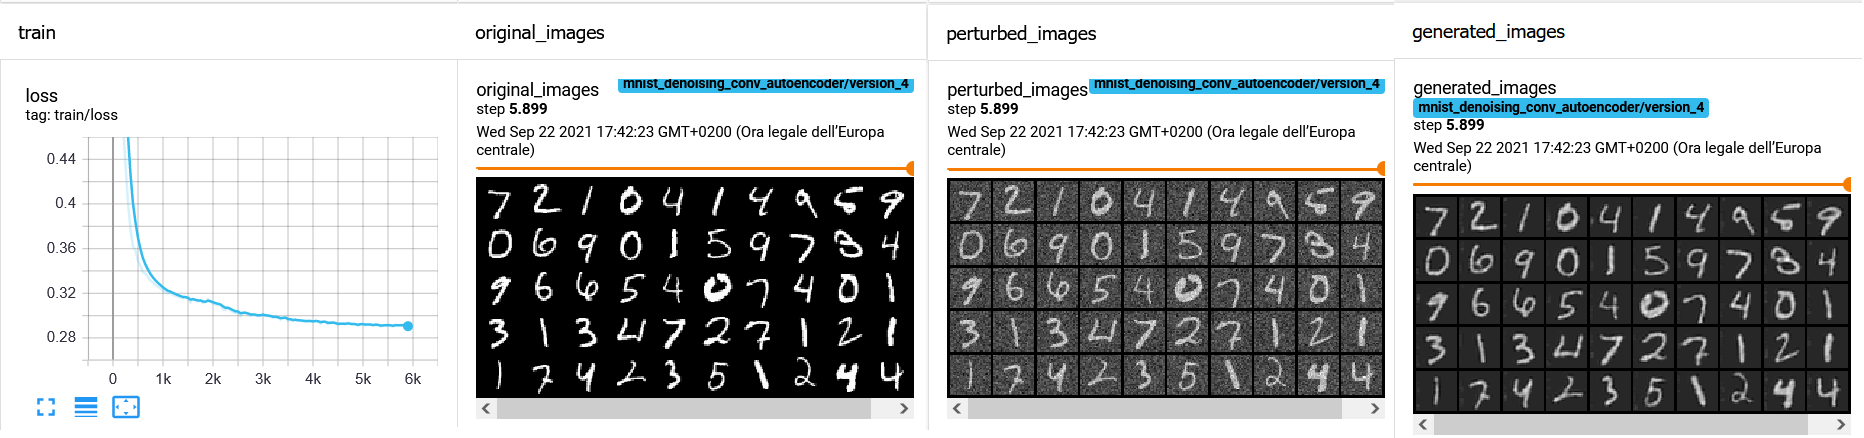

Procediamo adesso estraendo e visualizzando i codici con TSNE. Si noti che non passando `perturb=True`, le immagini in input a test time non saranno perturbate. Ciò ha senso in quanto la perturbazione serviva solo ad allenare un modello più robusto.

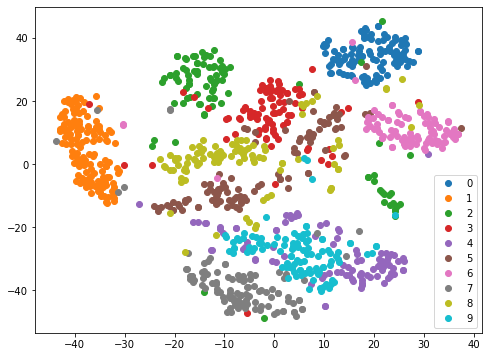

In [24]:
codes, labels = extract_codes(mnist_denoising_conv_autoencoder, mnist_test_loader)

selected_codes = np.random.choice(len(codes),1000)
codes = codes.reshape(codes.shape[0],-1)
codes = codes[selected_codes]
labels = labels[selected_codes]

tsne = TSNE(2)
codes_tsne_conv_denoising=tsne.fit_transform(codes)

plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne_conv_denoising[labels==c, 0], codes_tsne_conv_denoising[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<div>
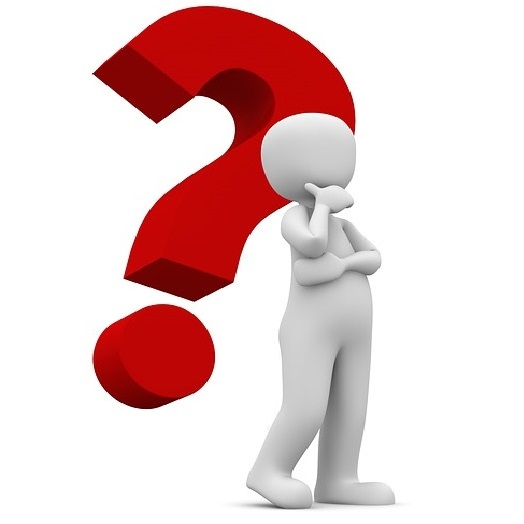
</div>

**Domanda 8**

Si confronti il grafico ottenuto con quello dell'autoencoder basato su convoluzioni ma non denoising. Uno dei due trasforma i dati in maniera più "coerente" con le classi? Se sì, quale?

<div>
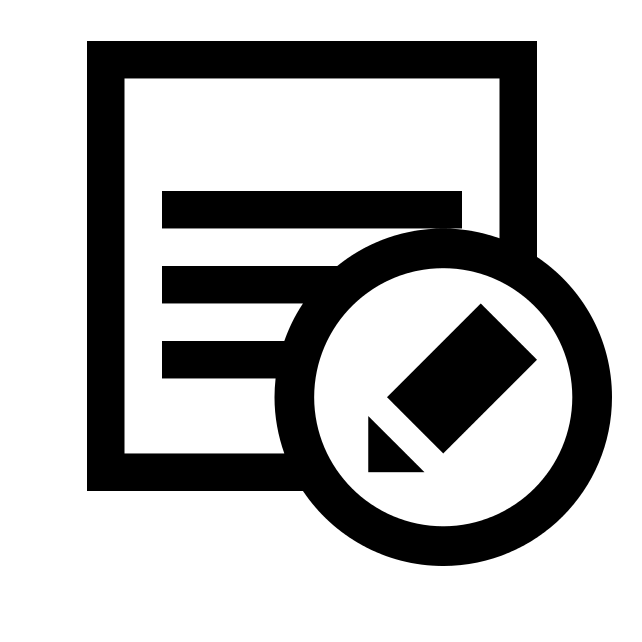
</div>

**Risposta 8**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 3.2 Sparse Autoencoders

Un altro modo per evitare l'autoencoder apprenda semplicemente la funzione identità, consiste nel limitare le forme che il codice interno all'autoencoder può assumere. In particolare, gli sparse autoencoders impongono un vincolo di sparsità sulle unità del codice. Ciò può essere fatto in diversi modi. Noi vedremo come farlo sommando alla loss una penalità L1. 

Se $\hat{\mathbf{z}}$ è il codice e $N$ è la dimensione del codice, il vincolo di sparsità può essere espresso come: $\sum_i^N |\hat{z}_i-s|$, dove $s$ è una piccola costante che indica il parametro di sparsità. 

La loss finale è duqnue:

$L(x, \hat{x}, \hat{z}) = MSE(x, M(x)) + \beta \sum_i^N |\hat{z}_i-s|$

Dove $x$ è l'immagine di input, $\hat x$ è quella ricostruita e $\beta$ è un parametro che regola il contributo delle due loss.

Vediamo come modificare la definizione dell'autoencoder vista in precedenza per introdurre il vincolo di sparsità:

In [25]:
from torchvision.utils import make_grid

class SparseConvAutoencoder(pl.LightningModule):
    def __init__(self):
        super(SparseConvAutoencoder, self).__init__() 
        self.encoder = nn.Sequential(nn.Conv2d(1,16,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,8,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,4,3, padding=1),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Conv2d(4,8,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,16,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,1,3, padding=1))
        
        #la loss che utilizzeremo per il training
        self.criterion = nn.MSELoss()
        self.l1 = nn.L1Loss()
        
        self.s = 0.05
        self.beta = 0.5
        
    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed
    
    # questo metodo definisce l'optimizer
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.01, momentum=0.99) 
        return optimizer
    
    # questo metodo definisce come effettuare ogni singolo step di training
    def training_step(self, train_batch, batch_idx):
        x, _ = train_batch
        code, reconstructed = self.forward(x)
        
        #definiamo il vincolo di sparsità
        #mediante loss l1
        sparse_loss = self.l1(torch.ones_like(code)*self.s, code)
        #sommiamo la loss MSE alla loss di sparsità moltiplicata per beta
        loss = self.criterion(x, reconstructed) + self.beta * sparse_loss
        
        self.log('train/loss', loss)
        return loss
    
    # questo metodo definisce come effettuare ogni singolo step di validation
    def validation_step(self, val_batch, batch_idx):
        x, _ = val_batch
        _, reconstructed = self.forward(x)
        loss = self.criterion(x, reconstructed)
        
        self.log('val/loss', loss)
        if batch_idx==0:
            return {'inputs':x, 'outputs':reconstructed}
        
    def validation_epoch_end(self, results):
        images_in = results[0]['inputs'].view(-1,1,28,28)[:50,...]
        images_out = results[0]['outputs'].view(-1,1,28,28)[:50,...]
        self.logger.experiment.add_image('input_images', make_grid(images_in, nrow=10, normalize=True),self.global_step)
        self.logger.experiment.add_image('generated_images', make_grid(images_out, nrow=10, normalize=True),self.global_step)

Alleniamo il modelllo:

In [26]:
logger = TensorBoardLogger("tb_logs", name="mnist_sparse_conv_autoencoder")
mnist_sparse_conv_autoencoder = SparseConvAutoencoder()
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, gpus=1, logger=logger) 
trainer.fit(mnist_sparse_conv_autoencoder, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 1.6 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
3 | l1        | L1Loss     | 0     
-----------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/furnari/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Alla fine del training, dovremmo visualizzare dei grafici simili a questi su tensorboard:

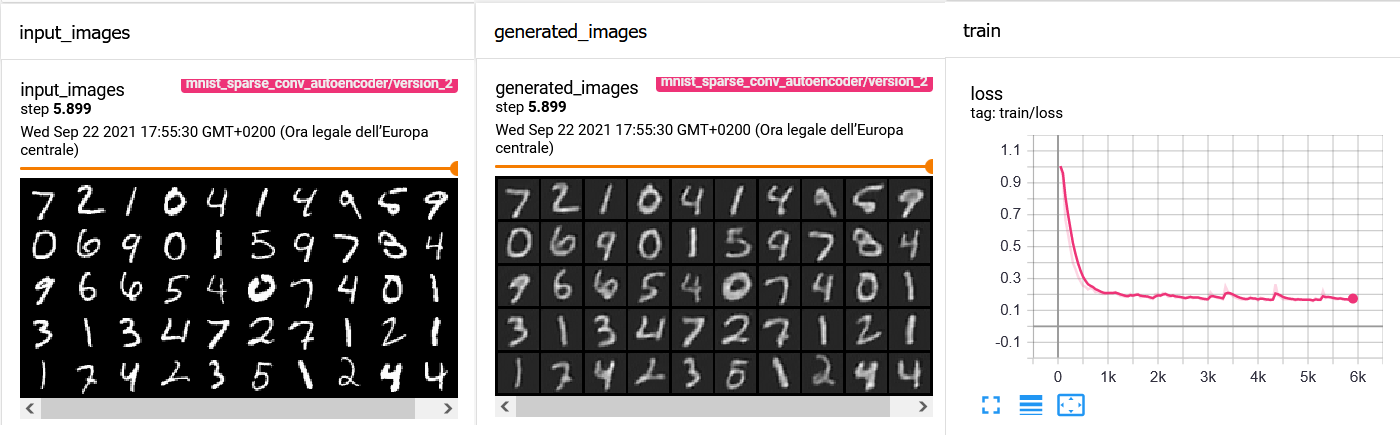

Visualizziamo i codici estratti da questo modello:

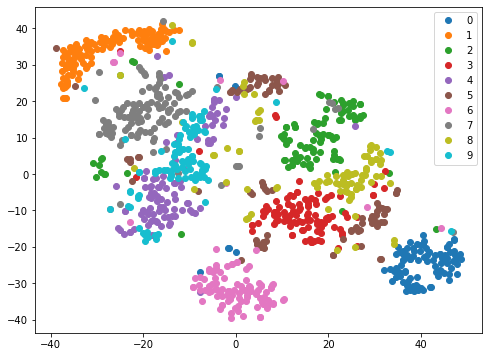

In [27]:
codes, labels = extract_codes(mnist_sparse_conv_autoencoder, mnist_test_loader)

selected_codes = np.random.choice(len(codes),1000)
codes = codes.reshape(codes.shape[0],-1)
codes = codes[selected_codes]
labels = labels[selected_codes]

tsne = TSNE(2)
codes_tsne_conv_sparse=tsne.fit_transform(codes)

plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne_conv_sparse[labels==c, 0], codes_tsne_conv_sparse[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<div>
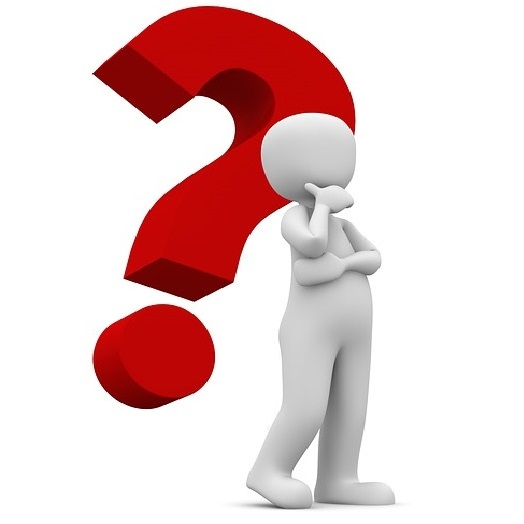
</div>

**Domanda 9**

Si confronti il grafico ottenuto con quelli ottenuti in precedenza. In quale caso i dati sono stati trasformati in maniera più "coerente" con le classi? Perché?

<div>
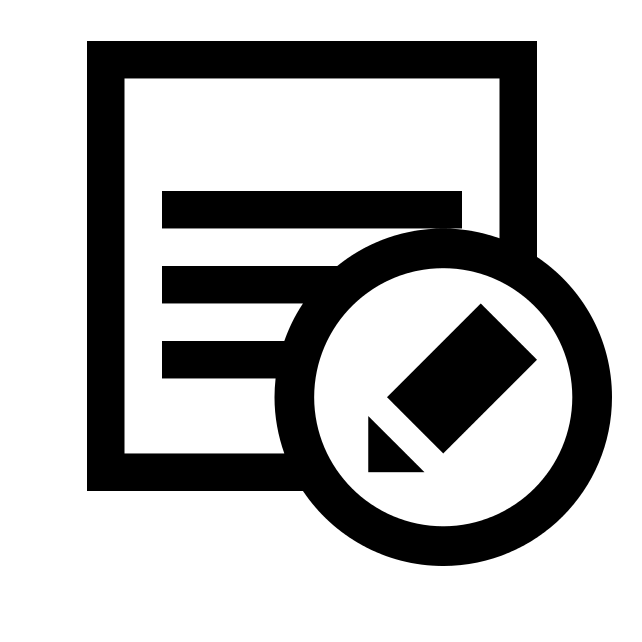
</div>

**Risposta 9**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 4 Applicazioni

Negli esempi visti finora, abbiamo verificato se gli autoencoder allenati fossero in grado di ricostruire correttamente l'input e costruire uno spazio di rappresentazione in cui elementi della stessa classe fossero vicini. Vediamo adesso alcuni esempi di applicazioni di autoencoder. 

Vedremo i seguenti esempi di applicazione:

 * unsupervised representation learning
 * dimensionality reduction
 * anomaly detection

## 4.1 Unsupervised representation learning

Un autoencoder permette di apprendere rappresentazioni dell'input in maniera non supervisionata (non sono necessarie le etichette per il training). Per verificare che le rappresentazioni apprese sono in effetti buone per la classificazione, proveremo ad allenare un semplice classificatore nearest neighbor utilizando un piccolo sottoinsieme di 100 codici estratti. Se la rappresentazione è sufficientemente buona, il classificatore avrà buone performance anche con un insieme limitati di dati. Confronteremo questo approccio con un nearest neighbor applicato direttamente alle immagini (intesi come valori dei pixel).

Iniziamo estraendo i codici di training e di test usando l'ultimo modello allenato. Selezioneremo un sottoinsieme di 100 esempi di training presi casualmente.

In [28]:
codes_train, labels_train = extract_codes(mnist_sparse_conv_autoencoder, mnist_train_loader)
codes_train = codes_train.reshape(codes_train.shape[0],-1)

selected_codes = np.random.choice(len(codes),100)
codes_train = codes[selected_codes]
labels_train = labels[selected_codes]

codes_test, labels_test = extract_codes(mnist_sparse_conv_autoencoder, mnist_test_loader)
codes_test = codes_test.reshape(codes_test.shape[0],-1)

Alleniamo adesso un classificatore 1-NN mediante sci-kit learn e visualizziamo l'accuracy sul test set:

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(codes_train, labels_train)
knn.score(codes_test, labels_test)

0.7047

Ripetiamo lo stesso procedimento con le immagini. In questo caso vedremo ogni esempio come un vettore di 784 elementi. Iniziamo estraendo le immagini:

In [30]:
#utilizzeremo lo stesso sottoinsieme
images_train = np.vstack([mnist_train[i][0].view(-1) for i in selected_codes])
labels_train = np.hstack([mnist_train[i][1] for i in selected_codes])

images_test = np.vstack([mnist_test[i][0].view(-1) for i in range(len(mnist_test))])
labels_test = np.hstack([mnist_test[i][1] for i in range(len(mnist_test))])

Adesso effettuiamo la valutazione con K-NN:

In [31]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(images_train, labels_train)
knn.score(images_test, labels_test)

0.7003

<div>
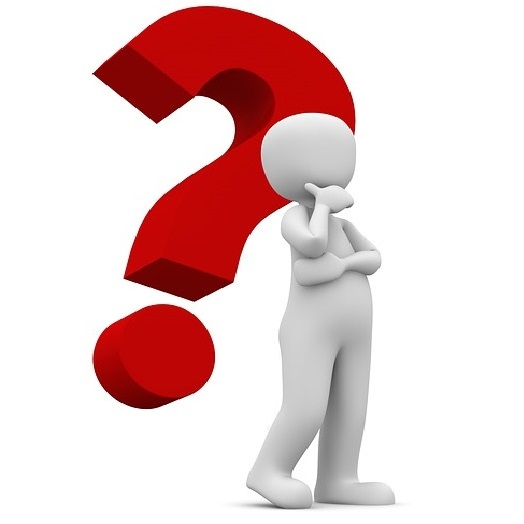
</div>

**Domanda 10**

Quale dei due classificatori ha le performance migliori? Perché?

<div>
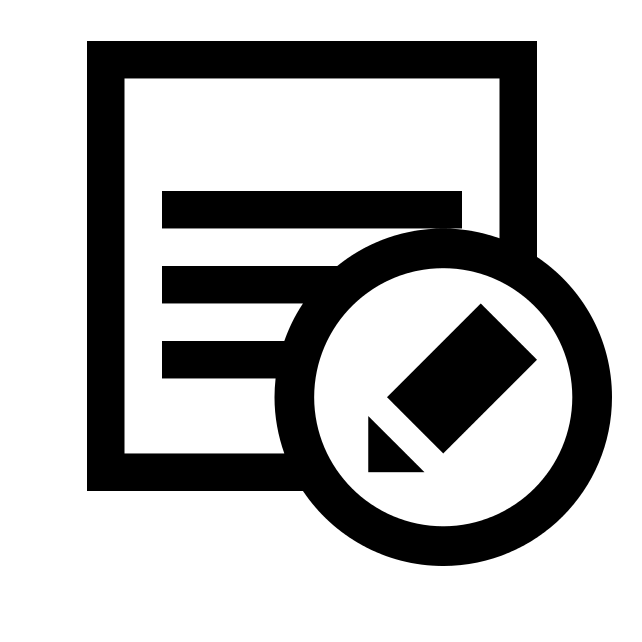
</div>

**Risposta 10**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 4.2 Dimensionality Reduction

Gli autoencoder permettono anche di ridurre la dimensionalità dei dati di input. Infatti, dato che l'autoencoder è capace di ricostruire le immagini di input dai codici, è possibile conservare i codici in luogo delle immagini riducendone la dimensione e risparmiando spazio. La riduzione della dimensione può essere anche utile per ridurre i requisiti computazionali di un possibile algoritmo che lavorerà sui codici piuttosto che sulle immagini. Vediamo con un semplice esempio quanto spazio possiamo risparmiare conservando i codici invece delle immagini.

Iniziamo confrontando lo spazio occupato in memoria in numero di byte dal test set quando conservato come immagini e quando conservato come codici. Utilizzeremo il primo autoencoder, che ha dei codici più piccoli:

In [32]:
for batch in mnist_test_loader:
    break

In [33]:
batch[0].shape

torch.Size([1024, 1, 28, 28])

In [34]:
#estriamo i codici
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,)),
                                torch.flatten])

mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=2)
codes_test, labels_test = extract_codes(mnist_autoencoder, mnist_test_loader)

#rappresentiamo le immagini a 8 bit
mnist_test_raw = MNIST(root='mnist',train=False, download=True,  \
                        transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x*255)]))
images_test_raw = np.vstack([mnist_test_raw[i][0].view(-1) for i in range(len(mnist_test_raw))]).astype(np.uint8)

In [35]:
print(f"Dimensione occupata dalle immagini: {images_test_raw.nbytes}")
print(f"Dimensione occupata dai codici: {codes_test.nbytes}")
print(f"Rapporto di compressione: {100-codes_test.nbytes/images_test_raw.nbytes*100:0.2f}%")

Dimensione occupata dalle immagini: 7840000
Dimensione occupata dai codici: 5120000
Rapporto di compressione: 34.69%


<div>
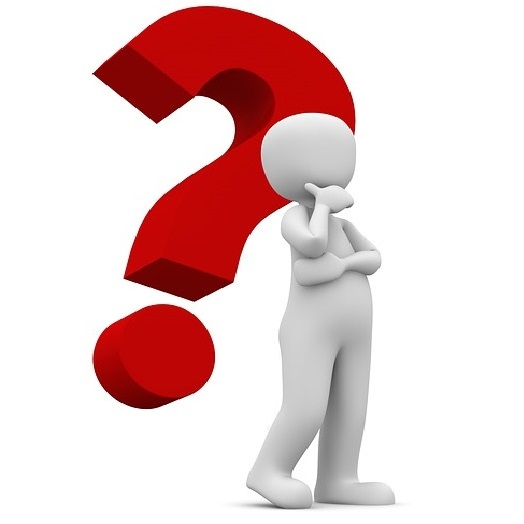
</div>

**Domanda 11**

Come mai otteniamo una compressione di circa il 35% Si faccia un esempio su una singola immagine. Ci sono modi per aumentare ancora il rapporto di compressione?

<div>
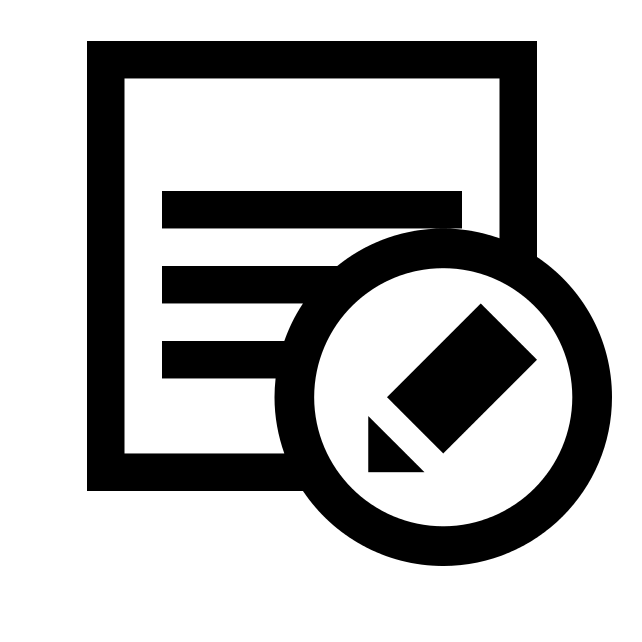
</div>

**Risposta 11**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Una volta conservati i codici, possiamo ricostruire le immagini in input utilizzando solo il decoder:

In [36]:
decoder = mnist_autoencoder.decoder

def decode(code):
    output_image = decoder(code)
    #l'immagine in output è normalizzata come quelle che abbiamo passato in input
    #invertiamo la normalizzazione:
    return output_image*0.3081 + 0.1307

Visualizziamo adesso la ricostruzione del codice:

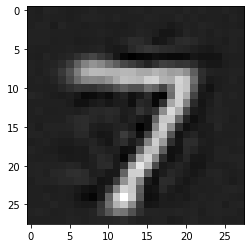

In [37]:
out_img=decode(torch.from_numpy(codes_test.copy()).cuda()).reshape(-1,1,28,28)
plt.imshow(out_img[0][0].detach().cpu(), cmap='gray')

## 4.3 Anomaly Detection

L'anomaly detection è un'altra potenziale applicazione degli autoencoder. Una volta allenato un autoencoder con immagini appartenenti a una distribuzione (es. la distribuzione delle immagini di MNIST), ci aspettiamo che esso sia molto efficace nel codificare e ricostruire queste immagini e meno efficace nel codificare e ricostruire immagini di un altro dominio.

Vediamo ad esempio come le immagini del dataset FashionMNIST vengono ricostruite con il Convolutional Autoencoder allenato su MNIST. Iniziamo definendo il dataset FashionMNIST. Utilizzeremo le stesse trasformazioni con le quali è stato allenato il modello (e quindi media e deviazione standard di MNIST):

In [38]:
from torchvision.datasets import FashionMNIST
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 
fashion_train = FashionMNIST(root='fashion', download=True, transform=transform)
fashion_train_loader = DataLoader(fashion_train, batch_size=1024)

Vediamo ora un esempio di ricostruzione di una immagine di FashionMNIST. Calcoleremo anche la norma L2 tra le due immagini (input e ricostruita) per capire quanto sono dissimili:

Distanza fra le immagini: 17.80


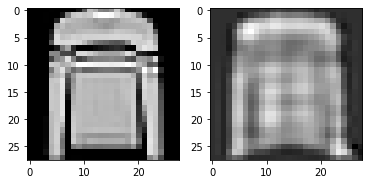

In [39]:
im_in_fashion = fashion_train[5][0]
code, im_out_fashion = mnist_conv_autoencoder(im_in_fashion.unsqueeze(0).cuda())
plt.subplot(1,2,1)
plt.imshow(im_in_fashion.squeeze().detach(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im_out_fashion.squeeze().cpu().detach(), cmap='gray')
print(f"Distanza fra le immagini: {(im_in_fashion.cpu()-im_out_fashion.cpu()).norm(2):0.2f}")

Vediamo adesso un esempio analogo con una immagine di MNIST:

Distanza fra le immagini: 7.09


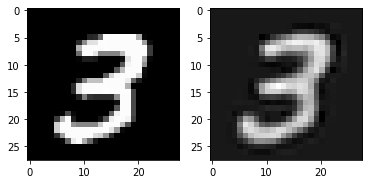

In [40]:
im_in_mnist = mnist_train[7][0]
code, im_out_mnist = mnist_conv_autoencoder(im_in_mnist.unsqueeze(0).cuda())
plt.subplot(1,2,1)
plt.imshow(im_in_mnist.squeeze().detach(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im_out_mnist.squeeze().cpu().detach(), cmap='gray')
print(f"Distanza fra le immagini: {(im_in_mnist.cpu()-im_out_mnist.cpu()).norm(2):0.2f}")

<div>
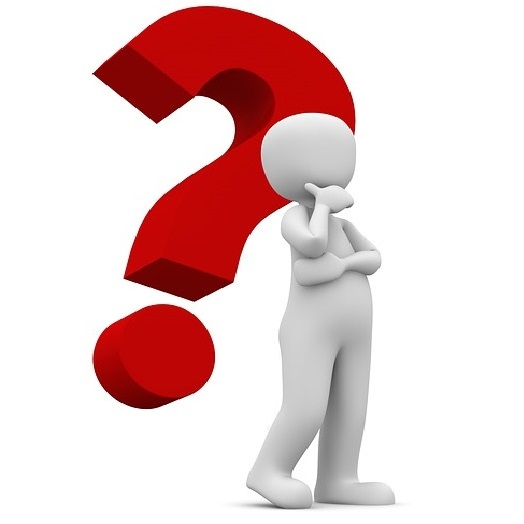
</div>

**Domanda 12**

Quale delle due immagini è stata ricostruita meglio? Come mai?

<div>
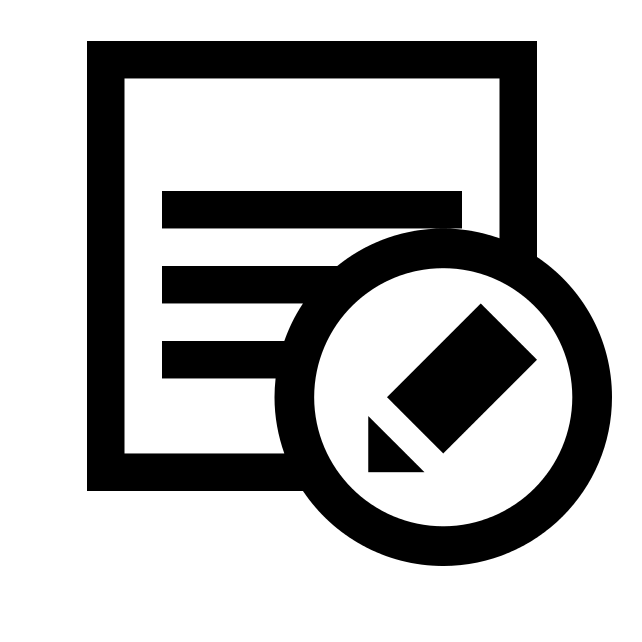
</div>

**Risposta 12**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Vediamo adesso se quanto osservato per le immagini di esempio si verifica sistematicamente o meno. Lo faremo calcolando la norma L2 media tra input e output per i due dataset:

In [41]:
from tqdm import tqdm
norms_fashion=[]
for im, _ in tqdm(fashion_train_loader):
    _, im_out = mnist_conv_autoencoder(im.cuda())
    n=(im-im_out.cpu()).view(im.shape[0],-1).norm(2, dim=-1)
    norms_fashion.append(n.detach().numpy())
norms_fashion = np.concatenate(norms_fashion)
print("Media delle norme L2 per FashionMNIST:",norms_fashion.mean())

100%|██████████| 59/59 [00:09<00:00,  6.40it/s]

Media delle norme L2 per FashionMNIST: 12.477457


In [42]:
norms_mnist=[]
for im, _ in tqdm(mnist_train_loader):
    _, im_out = mnist_conv_autoencoder(im.cuda())
    n=(im-im_out.cpu()).view(im.shape[0],-1).norm(2, dim=-1)
    norms_mnist.append(n.detach().numpy())
norms_mnist = np.concatenate(norms_mnist)
print("Media delle norme L2 per MNIST:",norms_mnist.mean())

100%|██████████| 59/59 [00:06<00:00,  9.34it/s]

Media delle norme L2 per MNIST: 7.2794585


Come è possibile vedere, le norme L2 per MNIST tendono ad essere più basse. Possiamo visualizzarlo anche mediante dei boxplot:

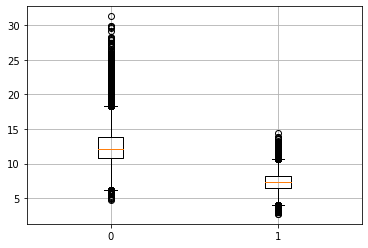

In [43]:
plt.figure()
plt.boxplot([norms_fashion, norms_mnist], positions=[0,1])
plt.grid()
plt.show()

<div>
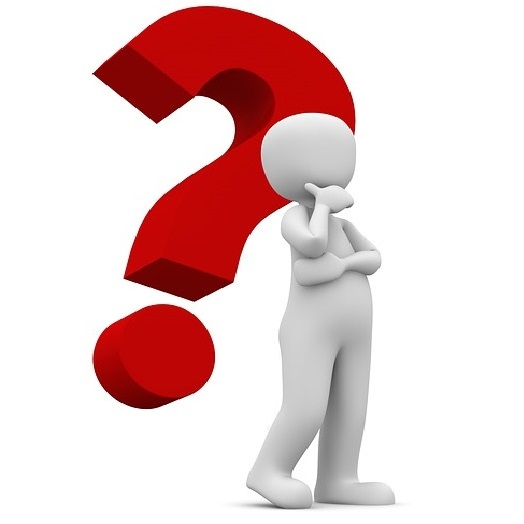
</div>

**Domanda 13**

Cosa possiamo dire delle due popolazioni? Sono ben distinte? Quanto è plausibile che elementi appartenenti ai due dataset possano essere discriminati a partire da questi valori?

<div>
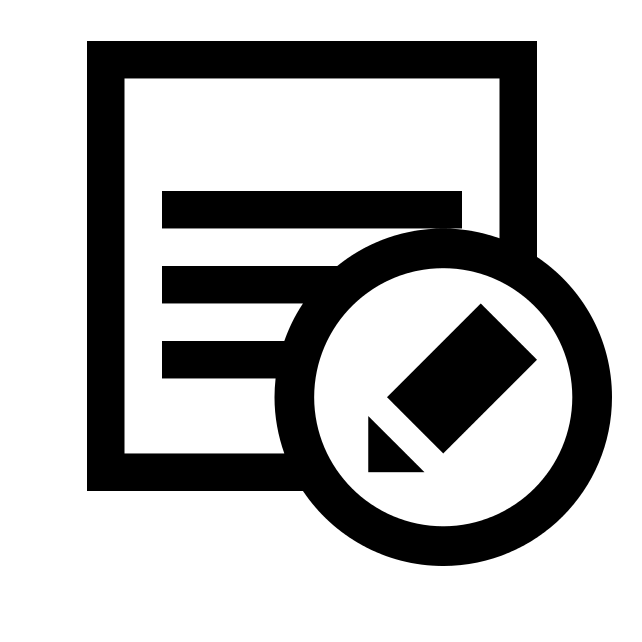
</div>

**Risposta 13**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Se volessimo costruire un sistema di anomaly detection, potremmo semplicemente allenare un regressore logistico sulle norme L2:

In [44]:
from sklearn.linear_model import LogisticRegression

#gli elementi in input saranno tutte le norme L2
x_train = np.concatenate([
        norms_fashion, 
        norms_mnist
    ]).reshape(-1,1)

#definiamo le etichette
y_train = np.concatenate([
           np.ones_like(norms_fashion)*-1, #negative examples: fashion
           np.ones_like(norms_mnist),#positive examples
       ]).reshape(-1,1)

lr = LogisticRegression()
lr.fit(x_train, y_train)

/home/furnari/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

Scriviamo adesso una funzione che prende una immagine e la classifica come positivo (appartenente alla classe MNIST) o negativo (non appartenente a MNIST - anomalia):

In [45]:
def detect_anomaly(example):
    _, im_out = mnist_conv_autoencoder(example.unsqueeze(0).cuda())
    
    return lr.predict((im_out.cpu()-example).norm(2).detach().numpy().reshape(-1,1))

Definiamo i dataset di set e testiamo la funzione sui 1000 elementi casuali di ciascun dataset:

In [46]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)
fashion_test = FashionMNIST(root='fashion', train=False, download=True, transform=transform)

Adesso testiamo sui 1000 elementi selezionati casualmente:

In [47]:
predictions_mnist = []
predictions_fashion = []
for i in tqdm(np.random.choice(len(mnist_test), 1000)):
    prediction_mnist = detect_anomaly(mnist_test[i][0])
    prediction_fashion = detect_anomaly(fashion_test[i][0])
    predictions_mnist.append(prediction_mnist)
    predictions_fashion.append(prediction_fashion)

predictions_mnist = np.array(predictions_mnist)
predictions_fashion = np.array(predictions_fashion)

print(f"Percentuale di elementi di MNIST classificati correttamente: {(predictions_mnist==1).mean()*100:0.2f}%")
print(f"Percentuale di elementi di Fashion-MNIST classificati correttamente: {(predictions_fashion==-1).mean()*100:0.2f}%")

100%|██████████| 1000/1000 [00:02<00:00, 337.70it/s]

Percentuale di elementi di MNIST classificati correttamente: 95.00%
Percentuale di elementi di Fashion-MNIST classificati correttamente: 91.00%


<div>
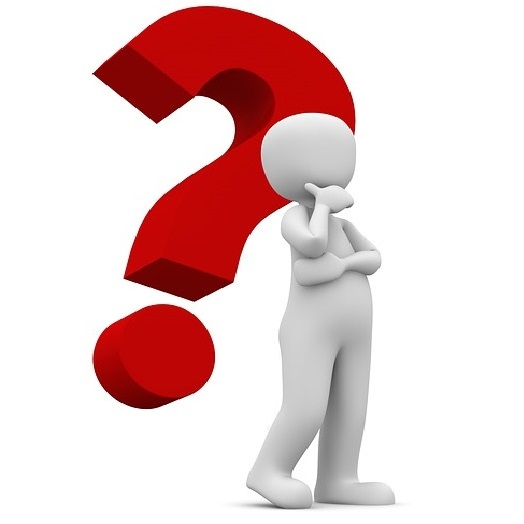
</div>

**Domanda 14**

Quanto è accurato il sistema sviluppato?

<div>
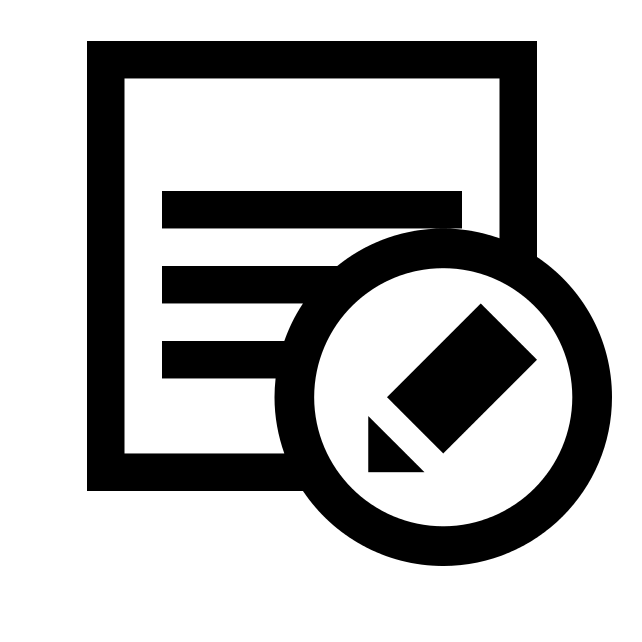
</div>

**Risposta 14**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# Esercizi
<div>
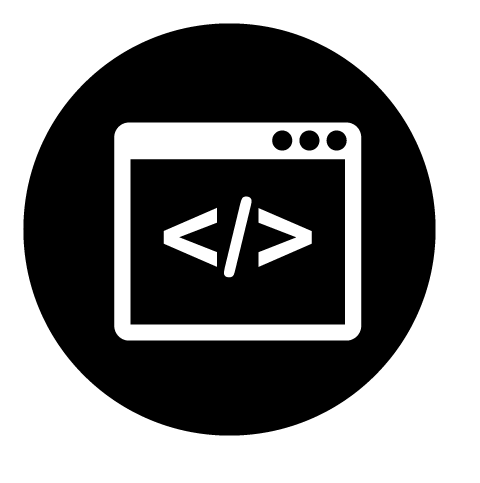
</div>

**Esercizio 1**

Si scriva mediante PyTorch Lightning un algoritmo capace di classificare le immagini del dataset 8Scenes (https://people.csail.mit.edu/torralba/code/spatialenvelope/). Si effettui il training e il testing del modello mediante l'API offerta da Lightning.

<div>
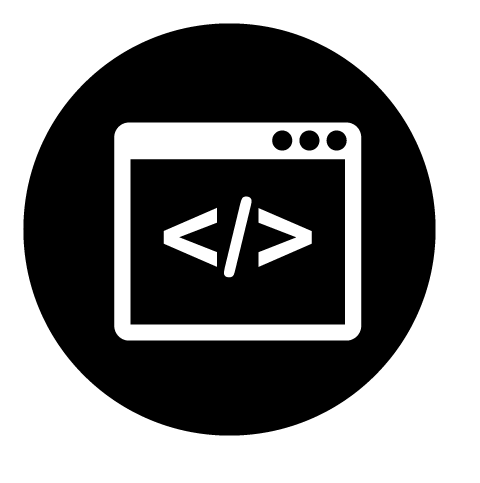
</div>

**Esercizio 2**

Si adatti l'autoencoder basato su convoluzioni per effettuare la classificazione dei dati di MNIST e si esegua il fine-tuning per questo task. Si confronti questo modello con un modello analogo allenato da zero. Quale dei due modelli converge prima? Il pre-training mediante autoencoder offre dei vantaggi?

<div>
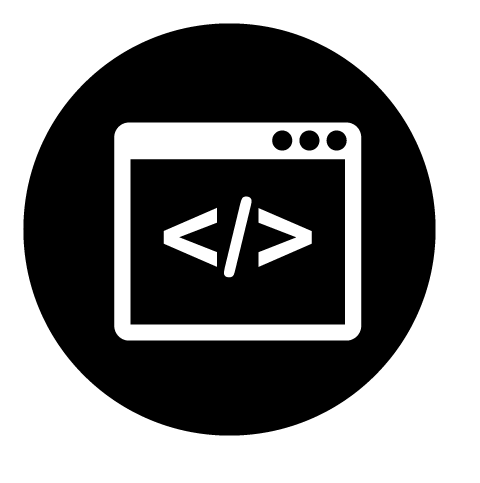
</div>

**Esercizio 3**

In questo laboratorio abbiamo comparato le performance dei diversi modelli solo in maniera qualitativa mediante proiezioni TSNE. Si confrontino le performance dei metodi utilizzando come task di destinazione quello della classificazione mediante KNN visto in relazione al representation learning. Quale modello offre la rappresentazione migliora?

<div>
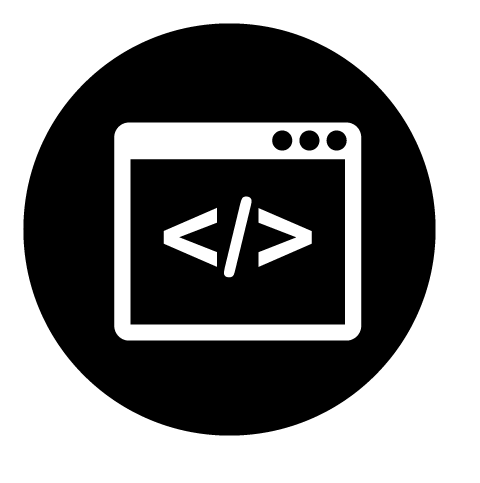
</div>

**Esercizio 4**

Si estenda l'esercizio precedente costruendo un modello che unisce le varie tecniche viste (uso di convoluzioni per costruire l'autoencoder, denoising, sparsity) per ottenere un modello più performante.

<div>
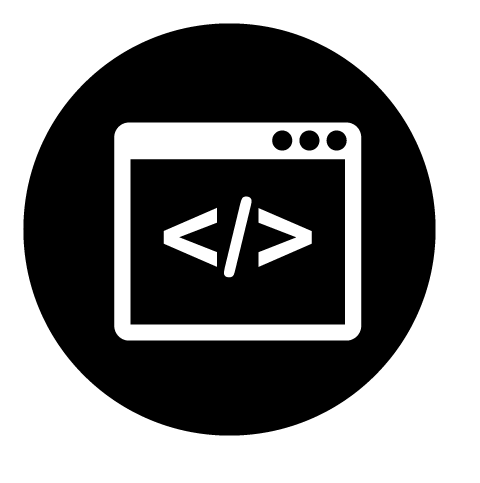
</div>

**Esercizio 5**

Si utilizzi il dataset disponibile a questo link (https://iplab.dmi.unict.it/UNICT-FD889/) per costruire un sistema di riconoscimento di immagini non raffiguranti cibo a partire da un autoencoder. Vista la complessità delle immagini, si consideri una CNN più complessa quale una ResNet.

# References

 * Documentazione di PyTorch. http://pytorch.org/docs/stable/index.html
 * Documentazione di PyTorch Lightning. https://www.pytorchlightning.ai/